In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
df=pd.read_csv('customer_churn_dataset-testing-master.csv')
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [96]:
df.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [97]:
df['Churn'].value_counts()

Churn
0    33881
1    30493
Name: count, dtype: int64

Since the churn values are close enough with each other I can use proper regression models.

# Encoding the object datas with OneHotEncoder

In [98]:
str_data=df.select_dtypes(include=["object"])

In [99]:
int_data=df.select_dtypes(include=["integer","float"])

In [100]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(str_data)

encoded_columns = encoder.get_feature_names_out(str_data.columns)


encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=df.index)


final_df = pd.concat([int_data, encoded_df], axis=1)

In [101]:
final_df.head()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
0,1,22,25,14,4,27,598,9,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2,41,28,28,7,13,584,20,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3,47,27,10,2,29,757,21,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,4,35,9,12,5,17,232,18,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,53,58,24,9,2,533,18,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


# Creating The Models

In [102]:
from sklearn.model_selection import train_test_split

X=final_df.drop(columns=["CustomerID","Age","Churn"], axis=1)
y=final_df["Churn"]

In [103]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

## Logistic Regression

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

Logistic_Regression_Model=LogisticRegression(max_iter=1000)
Logistic_Regression_Model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [105]:
y_pred=Logistic_Regression_Model.predict(X_test)

In [106]:
Logistic_Regression_Model.score(X_test, y_test)

0.829747572815534

In [107]:
accuracy=accuracy_score(y_test, y_pred)
report=classification_report(y_test, y_pred, output_dict=True)
report

{'0': {'precision': 0.8454722931371077,
  'recall': 0.8287943471220374,
  'f1-score': 0.8370502527505204,
  'support': 6793},
 '1': {'precision': 0.8129021879021879,
  'recall': 0.830812232818152,
  'f1-score': 0.821759635713124,
  'support': 6082},
 'accuracy': 0.829747572815534,
 'macro avg': {'precision': 0.8291872405196479,
  'recall': 0.8298032899700947,
  'f1-score': 0.8294049442318222,
  'support': 12875},
 'weighted avg': {'precision': 0.8300865548816682,
  'recall': 0.829747572815534,
  'f1-score': 0.8298271434051654,
  'support': 12875}}

### Logistic Regression Grid Search

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='saga'))
])
param_grid={
    'logreg__C': [0.01,0.1,1,10,100],
    'logreg__penalty': ['l1','l2'],
    'logreg__max_iter':[1000,2000]
}

In [111]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print('Best Params: ',grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Best Params:  {'logreg__C': 0.01, 'logreg__max_iter': 2000, 'logreg__penalty': 'l1'}
Best Score:  0.8236471596356324


## XGBoost Regressor

In [112]:
from xgboost import XGBClassifier
XGB_Model=XGBClassifier()

In [113]:
XGB_Model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
XGB_Predict=XGB_Model.predict(X_test)

In [115]:
XGB_Score=XGB_Model.score(X_test, y_test)
print(XGB_Score)

0.9666796116504854


%96 made me suspicious it might be overfitted. I'm gonna check it out.

### Confusion Matrix

In [116]:
pd.crosstab(y_test, XGB_Predict)

col_0,0,1
Churn,,
0,6549,244
1,185,5897


### Classification Report

In [117]:
from sklearn.metrics import classification_report
print(classification_report(y_test, XGB_Predict))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6793
           1       0.96      0.97      0.96      6082

    accuracy                           0.97     12875
   macro avg       0.97      0.97      0.97     12875
weighted avg       0.97      0.97      0.97     12875



### Train and Test Score Compare

In [118]:
print("Train Score: ", XGB_Model.score(X_train, y_train))
print("Test Score: ", XGB_Model.score(X_test, y_test))

Train Score:  0.995747490242529
Test Score:  0.9666796116504854


### Cross Validation

In [119]:
from sklearn.model_selection import cross_val_score
cross_val_score(XGB_Model, X,y, cv=20, scoring='accuracy').mean()

0.9646283931002435

Since all the values are highly close enough with each other we can't say it's overfitted. XGBoost has predicted with %96 accuracy.

### XGBoost Grid Search

In [120]:
from scipy.stats import randint, uniform

In [121]:
from sklearn.model_selection import RandomizedSearchCV
params={
    'gamma': uniform(0,0.5),
    'learning_rate': uniform(0.03,0.3),
    'max_depth': randint(2,6),
    'n_estimators':randint(100,150),
    'subsample':uniform(0.6,0.4)
}

In [122]:
random_search = RandomizedSearchCV(XGB_Model, param_distributions=params, cv=5, n_iter=30)
random_search.fit(X_train, y_train)
print('Best Params: ',random_search.best_params_)
print('Best Score: ', random_search.best_score_)

Best Params:  {'gamma': 0.03842071677556519, 'learning_rate': 0.15786875040968207, 'max_depth': 5, 'n_estimators': 101, 'subsample': 0.9494573847713708}
Best Score:  0.96485372601921


Result isn't changed so I'm gonna use normal model.

## Feature Importance

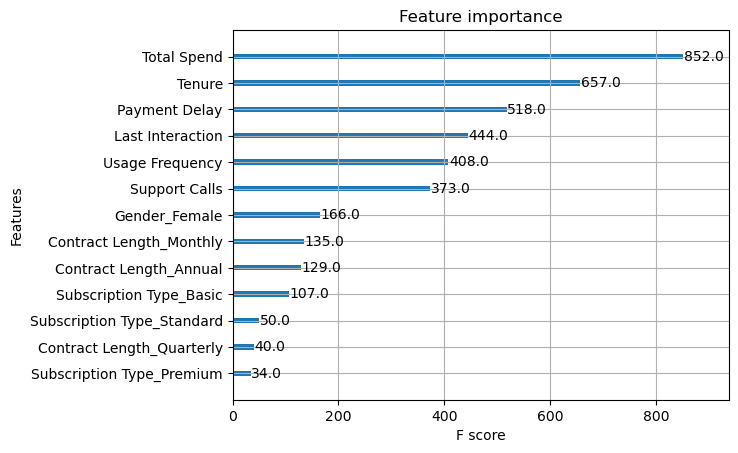

In [123]:
import xgboost as xgb
xgb.plot_importance(XGB_Model)
plt.show()

In [128]:
from sklearn.metrics import roc_auc_score, roc_curve

y_proba = XGB_Model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc_score = roc_auc_score(y_test, y_proba)
print("ROC AUC XGBoost: ", auc_score)

ROC AUC XGBoost:  0.9977959108630357


In [129]:
y_proba_logreg = Logistic_Regression_Model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba_logreg)
auc_score_logistic=roc_auc_score(y_test, y_proba_logreg)
print("ROC AUC Logistic Regression: ", auc_score_logistic)

ROC AUC Logistic Regression:  0.9067123181769267
